In [44]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sns

In [45]:
#Merged precipitation variables
#Added coordinates
#Transformed the temperature to Celsius and drop zero Kelvin values
#Transformed wind speed to m/s to km/h
#Rescale evi to have it between 0 and 1
#Add observation for 'NCR, City of Manila, First District'
#Droped 'Batanes' administration level, because it has no mosquito data

In [46]:
#Load the data and rename variables
df = pd.read_csv("Data/aggregated_adm2_median.csv")
df = pd.DataFrame(df)
df = df.rename(columns = {'JAXA_GPM_L3_GSMaP_v6_operational_hourlyPrecipRate':"perc",
 'JAXA_GPM_L3_GSMaP_v6_reanalysis_hourlyPrecipRate':'perc_real',
 'MODIS_006_MOD11A1_LST_Day_1km':"ls_temp_day",
 'MODIS_006_MOD11A1_LST_Night_1km' : "ls_temp_night",
 'MODIS_006_MYD13A1_EVI' : "evi",
 'NASA_FLDAS_NOAH01_C_GL_M_V001_Qair_f_tavg': "humid",
 'NASA_FLDAS_NOAH01_C_GL_M_V001_Tair_f_tavg': "ns_temp",
 'NASA_FLDAS_NOAH01_C_GL_M_V001_Wind_f_tavg': "wind_speed",
                         'adm_level':'adm_level','date':'date' })
adm = df.adm_level.unique() #list of administrative regions
dates = df.date.unique()
df.head()

,adm_level,date,ns_temp,.DS_Store,evi,perc_real,perc,ls_temp_day,wind_speed,humid,ls_temp_night
0,Abra,2012-01-01,294.942322,NaN,4201.00,0.677691,NaN,14983.25,4.523413,0.012944,14637.00
1,Abra,2012-02-01,295.359100,NaN,4226.50,56.856429,NaN,15064.00,4.341948,0.012925,14651.00
2,Abra,2012-03-01,296.557068,NaN,4028.25,39.567722,NaN,15172.00,3.893623,0.013058,14709.50
3,Abra,2012-04-01,298.167267,NaN,4679.00,90.904161,NaN,NaN,2.397629,0.014663,14710.00
4,Abra,2012-05-01,298.563477,NaN,4525.00,300.377629,NaN,15082.25,2.335809,0.015840,14594.75


In [47]:
df = df.drop('.DS_Store', axis = 1)

In [48]:
#Merge precipitation variables
index = df.perc.isnull()

percMerged = pd.DataFrame(np.empty((8352)), columns = list("p"))
percMerged = df.perc
percMerged[index] = df.perc_real[index]
df.perc = percMerged
df = df.drop("perc_real", axis = 1)

<ipython-input-48-d55d938a7d2c>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  percMerged[index] = df.perc_real[index]


In [49]:
#Add coordinates
df_m = pd.read_csv("Data/ovitrap_data_with_province.csv") #load mosquito data
coordinates = df_m[["latitude", "longitude","adm"]]

#add lond and latitude
adm = df.adm_level.unique() #list of administrative regions
long = dict.fromkeys(adm)
lat = dict.fromkeys(adm)

for administration in adm:
    long[administration] = df_m.longitude[df_m.adm == administration].mean()
    lat[administration] = df_m.latitude[df_m.adm == administration].mean()

df['longitude'] = df['adm_level'].map(long)
df['latitude'] = df['adm_level'].map(lat)

In [50]:
#Zero Kelvin values as NaN
df["ls_temp_day"] = df["ls_temp_day"].replace(0, np.nan)
df["ls_temp_night"] = df["ls_temp_night"].replace(0, np.nan)
df["ns_temp"] = df["ns_temp"].replace(0, np.nan)

In [51]:
#Transform the temperature to Celsius
df["ls_temp_day"] = df[["ls_temp_day"]].transform(lambda x: x*0.02-273.15)
df["ls_temp_night"] = df[["ls_temp_night"]].transform(lambda x: x*0.02-273.15)
df["ns_temp"] = df[["ns_temp"]].transform(lambda x: x-273.15)

In [52]:
#Night temperature below zero as NaN
df["ls_temp_night"] = df["ls_temp_night"].mask(df["ls_temp_night"] < 15)

In [53]:
#Transform wind speed to m/s to km/h
df["wind_speed"] = df["wind_speed"].transform(lambda x: x*3.6)

In [54]:
#Rescale evi to have it between 0 and 1
df["evi"] = df["evi"].transform(lambda x: x*0.0001)

In [55]:
#Add observation for 'NCR, City of Manila, First District'
#replicate data frame with new Hierarchical Indexes (adm primary)
df1 = df.set_index(['date', 'adm_level'])
df1 = df1.swaplevel(i='adm_level', j='date')
df1.sort_index(inplace = True)

#make a new data frame with Manila's neighbours and variables of interest (Hierarchical Indexes (date primary))
neighbours = ['NCR, Fourth District','NCR, Second District', 'NCR, Third District']
df2 = df1.loc[neighbours]
df2 = df2[['perc', 'humid', 'ns_temp', 'wind_speed']]
df2 = df2.swaplevel(j='adm_level', i='date')

#create dictionaries with dates as keys and empty values
dates =  df.date.unique()
perc_Manila = dict.fromkeys(dates)
humid_Manila = dict.fromkeys(dates)
ns_temp_Manila = dict.fromkeys(dates)
wind_speed_Manila = dict.fromkeys(dates)

#check values in neighbouring provinces and take an average for a given date
for date in dates:
    perc_Manila[date] = df2.loc[date].perc.mean()
    humid_Manila[date] = df2.loc[date].humid.mean()
    ns_temp_Manila[date] = df2.loc[date].ns_temp.mean()
    wind_speed_Manila[date] = df2.loc[date].wind_speed.mean()
    
#uodate missing values for Manila
idx = pd.IndexSlice
df1.loc[idx['NCR, City of Manila, First District',:],"perc"] = np.fromiter(perc_Manila.values(), dtype=float)
df1.loc[idx['NCR, City of Manila, First District',:],"humid"] = np.fromiter(humid_Manila.values(), dtype=float)
df1.loc[idx['NCR, City of Manila, First District',:],"ns_temp"] = np.fromiter(ns_temp_Manila.values(), dtype=float)
df1.loc[idx['NCR, City of Manila, First District',:],"wind_speed"] = np.fromiter(wind_speed_Manila.values(), dtype=float)

df1.loc['NCR, City of Manila, First District'] #check values fot Manila
#substitute original df with df1, where values for Manila are modified
df1.reset_index(inplace=True)
df = df1
df[df.adm_level == 'NCR, City of Manila, First District']

,adm_level,date,ns_temp,evi,perc,ls_temp_day,wind_speed,humid,ls_temp_night,longitude,latitude
5088,"NCR, City of Manila, First District",2012-01-01,25.186721,0.06970,49.153063,32.99,20.742857,0.016681,22.83,120.986894,14.606461
5089,"NCR, City of Manila, First District",2012-02-01,25.271987,0.09390,217.127876,36.21,20.718256,0.016701,24.93,120.986894,14.606461
5090,"NCR, City of Manila, First District",2012-03-01,25.837478,0.09325,73.877518,38.64,21.943444,0.016738,25.78,120.986894,14.606461
5091,"NCR, City of Manila, First District",2012-04-01,27.548466,0.11000,1.502089,NaN,14.733117,0.017386,26.75,120.986894,14.606461
5092,"NCR, City of Manila, First District",2012-05-01,28.561904,0.08950,254.275016,41.77,9.767565,0.018230,NaN,120.986894,14.606461
...,...,...,...,...,...,...,...,...,...,...,...
5179,"NCR, City of Manila, First District",2019-08-01,27.065424,0.10685,263.206283,32.37,23.618933,0.019686,26.71,120.986894,14.606461
5180,"NCR, City of Manila, First District",2019-09-01,26.940169,NaN,153.352934,37.97,17.458084,0.018733,24.29,120.986894,14.606461
5181,"NCR, City of Manila, First District",2019-10-01,27.270685,0.10045,102.547443,34.05,15.086960,0.017985,24.97,120.986894,14.606461
5182,"NCR, City of Manila, First District",2019-11-01,26.720972,0.07475,93.102326,27.54,15.780999,0.018407,23.90,120.986894,14.606461


In [56]:
df.to_csv(r'median_weather_transformed.csv')

In [57]:
df.head()

,adm_level,date,ns_temp,evi,perc,ls_temp_day,wind_speed,humid,ls_temp_night,longitude,latitude
0,Abra,2012-01-01,21.792322,0.420100,0.677691,26.515,16.284287,0.012944,19.590,120.688118,17.571437
1,Abra,2012-02-01,22.209100,0.422650,56.856429,28.130,15.631011,0.012925,19.870,120.688118,17.571437
2,Abra,2012-03-01,23.407068,0.402825,39.567722,30.290,14.017043,0.013058,21.040,120.688118,17.571437
3,Abra,2012-04-01,25.017267,0.467900,90.904161,NaN,8.631463,0.014663,21.050,120.688118,17.571437
4,Abra,2012-05-01,25.413477,0.452500,300.377629,28.495,8.408912,0.015840,18.745,120.688118,17.571437


In [58]:
df.describe()

,ns_temp,evi,perc,ls_temp_day,wind_speed,humid,ls_temp_night,longitude,latitude
count,8265.000000,7917.000000,8352.000000,7811.000000,8265.000000,8265.000000,6861.000000,8256.000000,8256.000000
mean,25.564807,0.452532,211.538143,28.451993,16.561143,0.016567,21.697531,122.810319,11.754101
std,1.869050,0.092133,221.812214,2.990912,5.691598,0.001474,1.889579,1.873849,3.669123
min,14.718652,0.056450,0.000000,16.700000,5.941396,0.009182,15.050000,118.889411,5.036891
25%,24.760339,0.412500,54.802672,26.697500,12.193307,0.015834,20.840000,121.055562,8.386214
50%,25.918604,0.467200,160.983911,28.090000,15.594569,0.016841,21.970000,122.639598,11.619438
75%,26.758630,0.512250,294.818129,29.570000,20.283289,0.017581,22.910000,124.593849,14.690377
max,30.123621,0.678900,3679.925535,43.470000,43.975429,0.019997,27.940000,126.227240,18.179736


evi


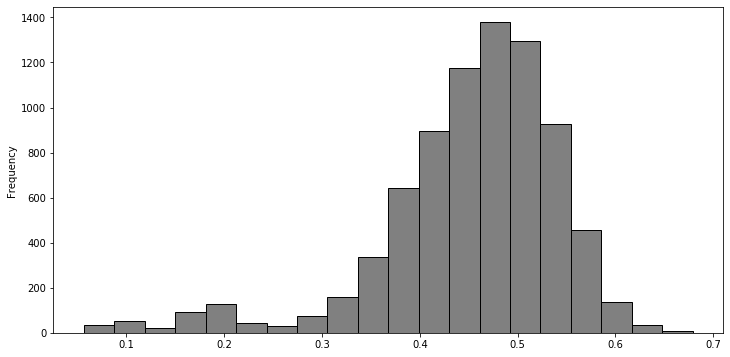

perc


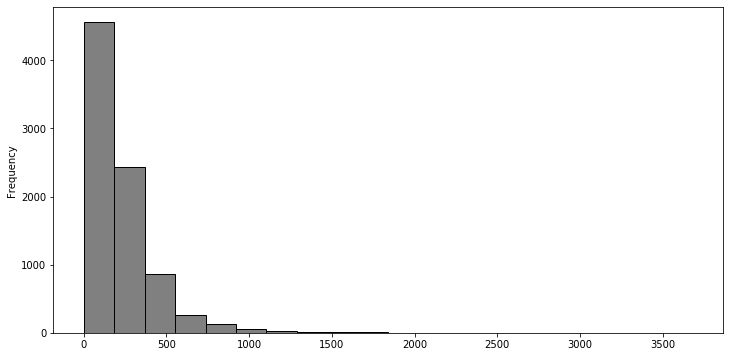

ls_temp_day


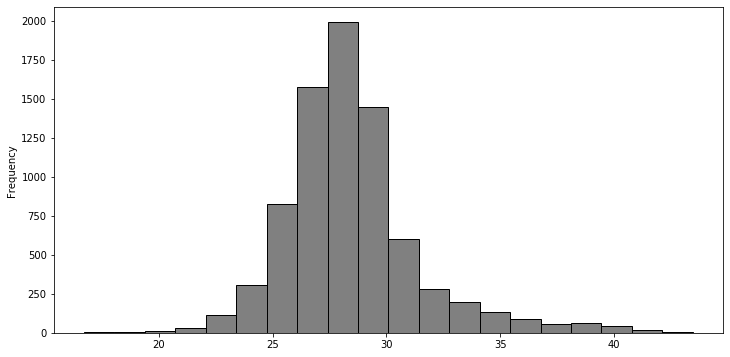

wind_speed


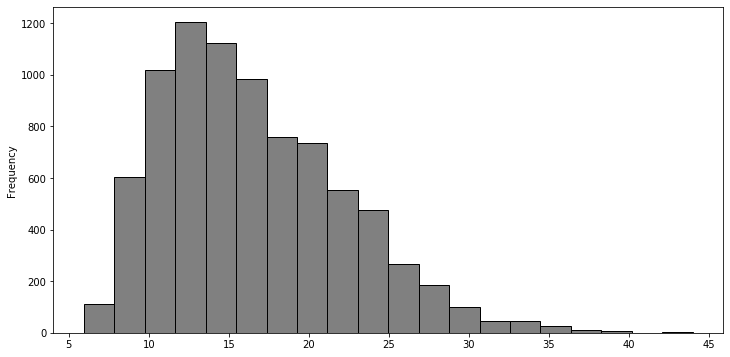

humid


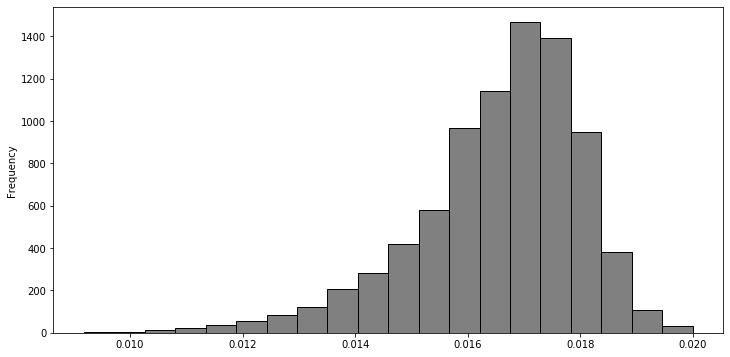

ls_temp_night


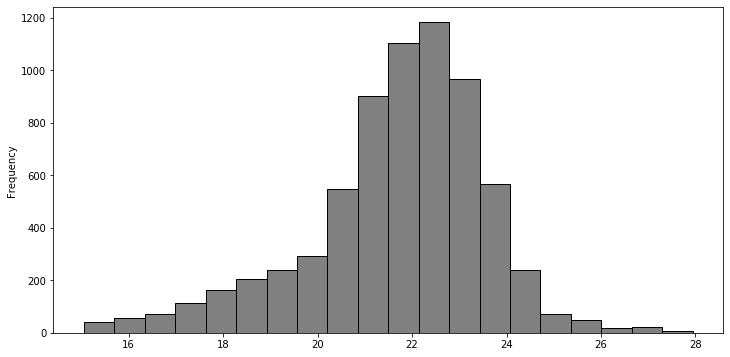

In [59]:
var_names = df.columns #list variable names
for variable in var_names[3:9]:
    print(variable)
    df[variable].plot(kind='hist', bins=20, figsize=(12,6), facecolor='grey',edgecolor='black')
    plt.show()

/Users/annakopyakova/opt/anaconda3/envs/seminar/lib/python3.8/site-packages/pandas/core/generic.py:6244: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


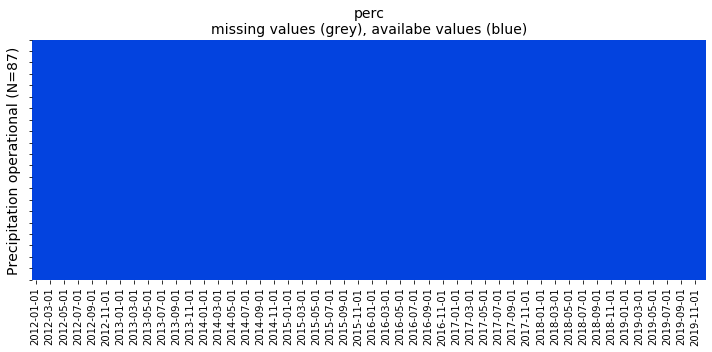

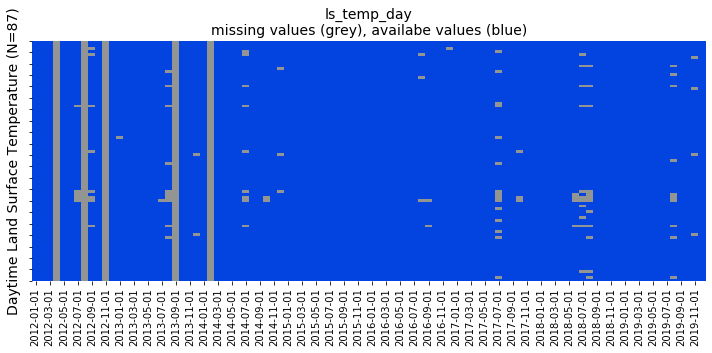

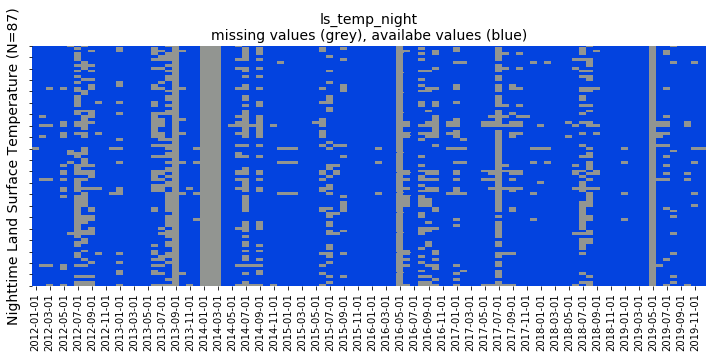

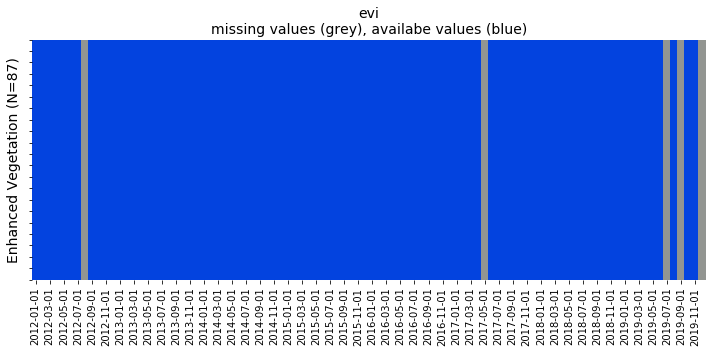

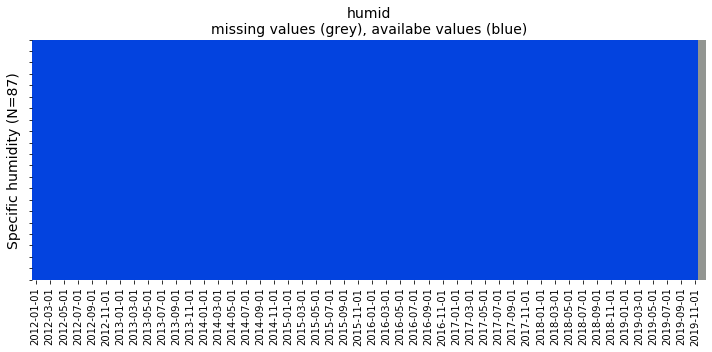

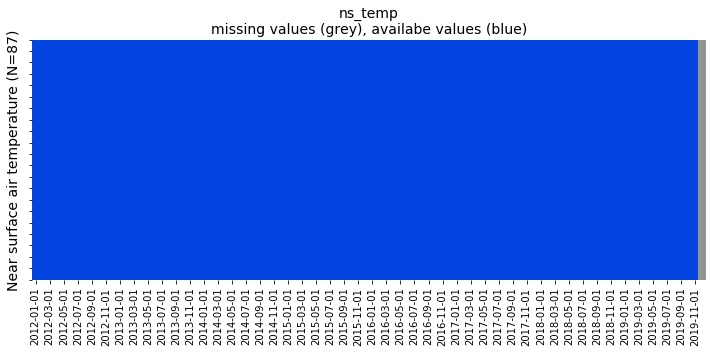

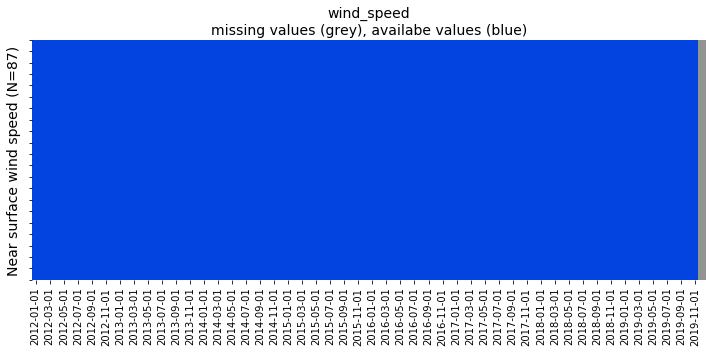

In [61]:
#Visualize missing values - code was found on the Internet
def missing_values_graph(frame, obs, time, var, Yname):
    test = frame[[obs, time, var]]
    test[var].fillna(-1, inplace=True)
    test = test.groupby([obs, time])[var].aggregate('mean').unstack()
    test[test > 0] = 1
    cmap = sns.xkcd_palette(["grey", "blue"])
    plt.figure(figsize=(10, 5))
    ax = sns.heatmap(test, center=0, cmap=cmap, cbar=False,
                     cbar_kws={'ticks': [-1, 0, 1]})
    ax.set(yticklabels=[])
    plt.ylabel(Yname+ " (N=" + str(len(test)) + ")", fontsize=14)
    plt.xlabel("")
    plt.title((var + "\nmissing values (grey), availabe values (blue)"),
              fontsize=14)
    plt.tight_layout()
    plt.show()

    
    
missing_values_graph(df, "adm_level", "date", "perc", "Precipitation operational")
#missing from 2012-01-01 until 2014-03-01; missing for "NCR, City of Manila, First District"
missing_values_graph(df, "adm_level", "date", "ls_temp_day", "Daytime Land Surface Temperature")
missing_values_graph(df, "adm_level", "date", "ls_temp_night", "Nighttime Land Surface Temperature")
missing_values_graph(df, "adm_level", "date", "evi", "Enhanced Vegetation")
missing_values_graph(df, "adm_level", "date", "humid", "Specific humidity")
#missing for "NCR, City of Manila, First District"; missing from 2019-11-01 
missing_values_graph(df, "adm_level", "date", "ns_temp", "Near surface air temperature")
#missing for "NCR, City of Manila, First District"; missing from 2019-11-01
missing_values_graph(df, "adm_level", "date", "wind_speed", "Near surface wind speed")
#missing for "NCR, City of Manila, First District"; missing from 2019-11-01